# Simulations with regressions

In [129]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [155]:
import sys
sys.path.append('./shapley_compute/')

## High number of independent features for linear regression

In [156]:
from shapley_compute.ensembled_mp import mp_shapley
from shapley_compute.minipatches import minipatch_regression_loo

In [133]:
def normal_linear_model(N, M, sigma2=0.4, s=0.2):
    """
    N: number of obs
    M: number of features
    sigma2: variance 
    s: sparsity level
    """ 
    np.random.seed(123)
    X = np.random.normal(0,1, size=(N,M))
    M1=int(s*M)
    beta = np.append(np.random.normal(5, 1, M1),np.array([0]*(M-M1))) # M-M1 beta are set to 0, M1 are non zeros
    eps = np.random.normal(0, sigma2, size=N)

    y = X@beta + eps
    return y, X, beta
    


In [134]:
N = 1000
M = 20
y, X, beta = normal_linear_model(N,M)

In [135]:
B = 10000
x_ratio = 0.2
model = LinearRegression()

In [136]:
X_test = X[np.unique(np.where(in_mp_loo==True)[1])]
X_train =  X[np.unique(np.where(in_mp_loo==False)[1])]
y_train =  y[np.unique(np.where(in_mp_loo==False)[1])]

In [137]:
X_test.shape, X_train.shape

((36, 20), (1000, 20))

<Axes: >

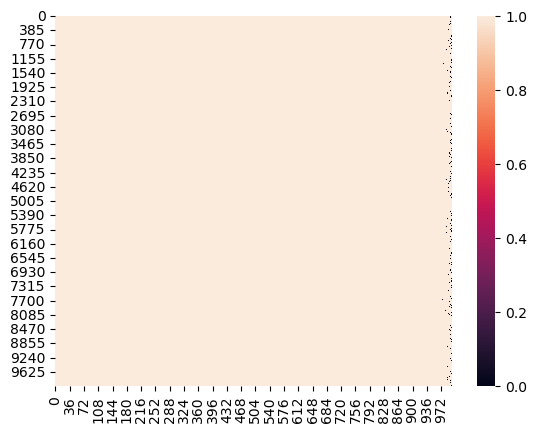

In [138]:
sns.heatmap(~in_mp_loo)

In [157]:
# fit a linear regression and evaluate shapley mp
res = minipatch_regression_loo(X_train, y_train, model, x_ratio, B)
pred, in_mp_obs, in_mp_loo, in_mp_feature = res
X_test = X[np.unique(np.where(in_mp_loo == True)[1]),:] 
shap_v = mp_shapley(X_test, res)

In [158]:
all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
print(all_features.shape[0], 2**M)

8014 1048576


<BarContainer object of 20 artists>

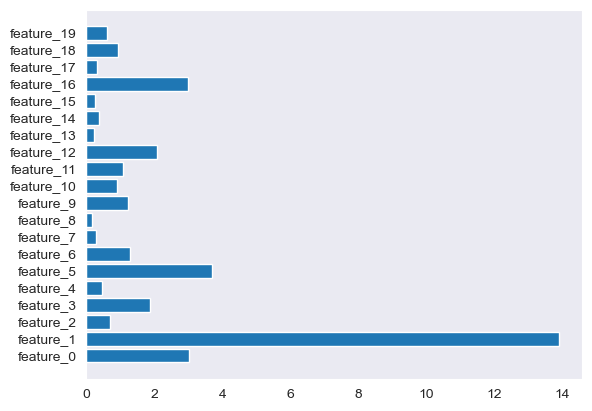

In [219]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0))

In [160]:
import shap
model = LinearRegression()
model.fit(X_train ,y_train)
explainer = shap.Explainer(model.predict, X_test)
## Calculates the SHAP values - It takes some time
shap_values_lr = explainer(X_test)

In [167]:
X_test.shape

(41, 20)

In [162]:
kernel_exp = shap.KernelExplainer(model.predict, X_test)
kernel_shap_values = kernel_exp(X_test)

100%|██████████| 41/41 [00:11<00:00,  3.62it/s]


In [177]:
shap_values_lr.values.shape

(41, 20)

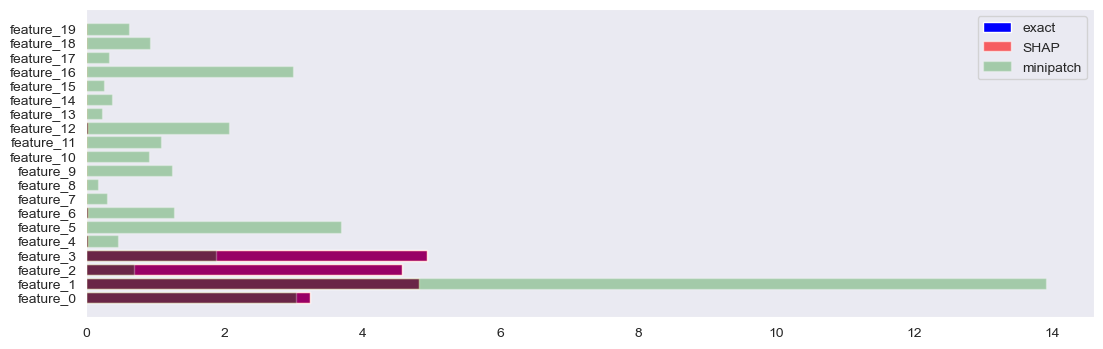

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(13,4))
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), color='blue')
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(kernel_shap_values.values),axis=0), color='red', alpha=0.6)
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), color='green', alpha=0.3)
ax.legend(['exact','SHAP', 'minipatch'])

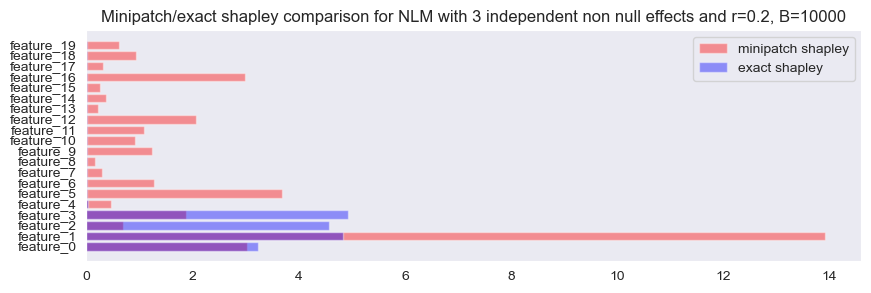

In [200]:
fig, ax = plt.subplots(figsize=(10,3))
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), alpha=0.4, color='red')
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), alpha = 0.4, color='blue')
ax.legend(['minipatch shapley', 'exact shapley'])
ax.set_title('Minipatch/exact shapley comparison for NLM with 3 independent non null effects and r={}, B={}'.format(x_ratio, B))
plt.savefig('./figures/NLM_shap_reg_2.svg')

In [123]:
import tqdm

In [128]:
res[2].shape

(10000, 1000)

In [212]:
x_ratio = [0.03, 0.05, 0.1]
B = [5000, 10000, 20000]
shap_dict = {}
for i in tqdm.tqdm(range(len(x_ratio))):
    res = minipatch_regression_loo(X, y, model, x_ratio[i], B[i])
    X_test = X[np.unique(np.where(res[2] == True)[1]),:] 
    shap_dict[i] = mp_shapley(X_test, res)

100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


In [211]:
help(mp_shapley)

Help on function mp_shapley in module shapley_compute.ensembled_mp:

mp_shapley(Xi, res)



In [214]:
X_test.shape

(75, 20)

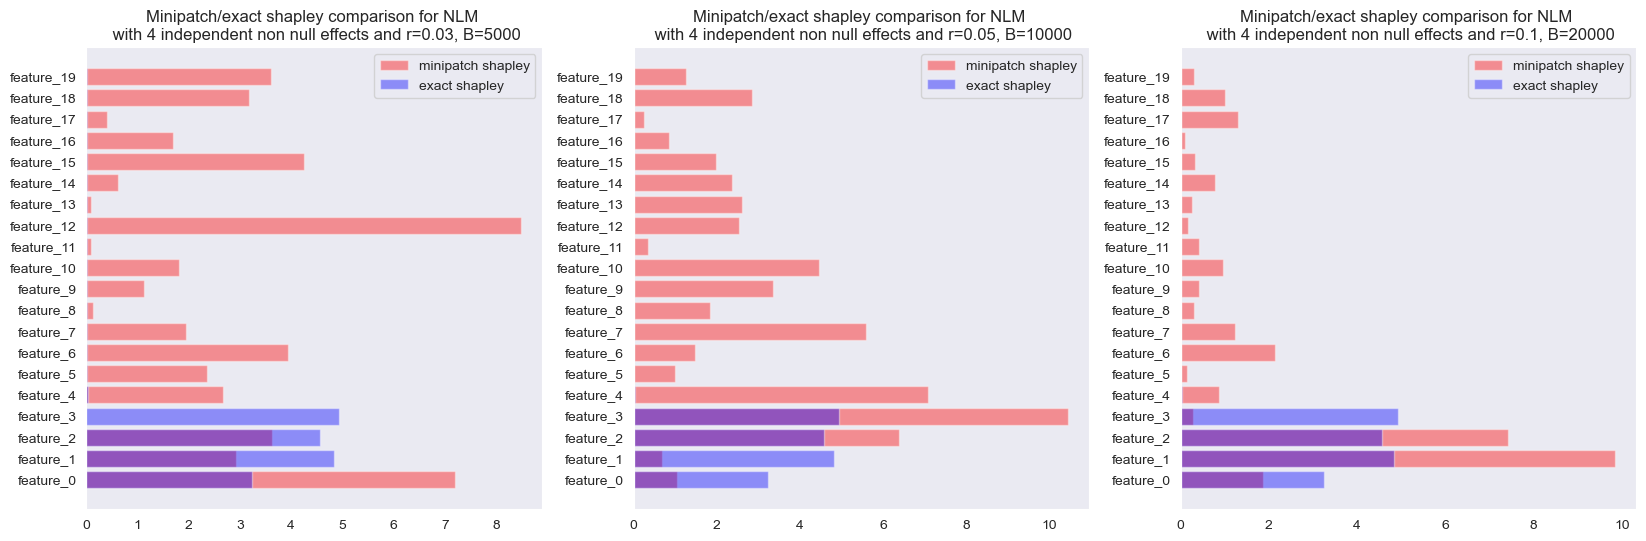

In [218]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
for i in range(len(x_ratio)):
    ax[i].barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_dict[i]),axis=0), alpha=0.4, color='red')
    ax[i].barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values), axis=0), alpha = 0.4, color='blue')
    ax[i].legend(['minipatch shapley', 'exact shapley'])
    ax[i].set_title('Minipatch/exact shapley comparison for NLM \n with {} independent non null effects and r={}, B={}'.format(len(beta[~(beta ==0)]), x_ratio[i], B[i]))
    # ax[i].yaxis.set_ticklabels([])
plt.savefig('./figures/NLM_shap_reg_2.svg')

(10000, 20)

[50.0, 500.0, 2000.0]